In [1]:
import muon as mu
import pertpy as pt
import scanpy as sc
from anndata import AnnData
import numpy as np
import jax.numpy as jnp
import scanpy as sc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


/home/tintra/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-16 09:24:29.877471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 09:24:29.884615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734341069.893676   29719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734341069.896387   29719 cuda_blas.cc:1418] Unable to 

Link dataset [Mouse -- all cells](https://datasets.cellxgene.cziscience.com/94a836ba-0a79-4f4a-9931-aa2a2cb7a22e.h5ad)

In [2]:
adata = sc.read_h5ad("194k.h5ad")
adata

AnnData object with n_obs × n_vars = 194315 × 22942
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'day', 'surgery', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP'

In [3]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset=True)
adata = adata[:, adata.var.highly_variable]

In [4]:
adata.obs['cell_type'].value_counts()

cell_type
granulocyte               28987
T cell                    25957
type B pancreatic cell    21129
macrophage                17476
endothelial cell          16991
monocyte                  16411
fibroblast                11229
hepatocyte                11170
B cell                    10541
kidney tubule cell        10138
dendritic cell             4954
pancreatic A cell          4122
unknown                    3315
pancreatic D cell          2698
pericyte                   2225
natural killer cell        2158
pancreatic PP cell          995
Kupffer cell                853
hepatic stellate cell       787
endocardial cell            737
fibrocyte                   591
exocrine cell               309
mature NK T cell            167
neutrophil                  146
Schwann cell                124
cardiac muscle cell         105
Name: count, dtype: int64

In [5]:
from sklearn.covariance import empirical_covariance, ledoit_wolf, shrunk_covariance
from numbers import Real
import numpy as np
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from time import time
from scipy.linalg import eig
from numpy import ndarray
import math


def power_method(A, num_iter=1000, tol=1e-6):
    """
    Finds the largest eigenvalue and corresponding eigenvector using the Power Method.
    """
    n = A.shape[0]
    b_k = np.random.rand(n)

    for _ in range(num_iter):
        # Multiply by the matrix
        b_k1 = np.dot(A, b_k)

        # Normalize the vector
        b_k1_norm = np.linalg.norm(b_k1)
        b_k1 = b_k1 / b_k1_norm

        # Check convergence
        if np.linalg.norm(b_k1 - b_k) < tol:
            break

        b_k = b_k1

    # Compute the Rayleigh quotient for the eigenvalue
    eigenvalue = np.dot(b_k.T, np.dot(A, b_k))

    return eigenvalue, b_k

def deflation(A, eigenvalue, eigenvector):
    """
    Performs deflation to remove the influence of a given eigenvalue and eigenvector.
    """
    return A - eigenvalue * np.outer(eigenvector, eigenvector)

def find_k_largest_eigenvalues(A, k, num_iter=1000, tol=1e-6):
    """
    Finds the k largest eigenvalues and their corresponding eigenvectors using the
    Power Method with Deflation.
    """
    n = A.shape[0]
    assert k <= n, "k cannot be larger than the size of the matrix"

    eigenvalues = []
    eigenvectors = []

    A_copy = A.copy()

    for _ in range(k):
        # Find the largest eigenvalue and eigenvector
        eigenvalue, eigenvector = power_method(A_copy, num_iter, tol)

        # Store the results
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)

        # Deflate the matrix
        A_copy = deflation(A_copy, eigenvalue, eigenvector)

    return np.array(eigenvalues), np.array(eigenvectors).T

def size(x):
    return math.prod(x.shape)

def compute_scatter_matrices(X, y):
    """
    Compute Within-Class Scatter (S_W) and Between-Class Scatter (S_B).
    
    Parameters:
    X : ndarray
        Feature matrix (n_samples, n_features).
    y : ndarray
        Class labels (n_samples,).
        
    Returns:
    S_W : ndarray
        Within-class scatter matrix (n_features, n_features).
    S_B : ndarray
        Between-class scatter matrix (n_features, n_features).
    """
    # Step 1: Compute overall mean
    overall_mean = np.mean(X, axis=0)
    
    # Step 2: Initialize scatter matrices
    n_features = X.shape[1]
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))
    
    # Step 3: Compute scatter matrices
    classes = np.unique(y)
    for _class in classes:
        # Extract samples of the current class
        X_class = X[y == _class]
        
        # Compute mean vector for the current class
        class_mean = np.mean(X_class, axis=0)
        
        # Compute within-class scatter (S_W)
        n_class_samples = X_class.shape[0]
        X_class_centered = X_class - class_mean  # Center the data
        S_W += X_class_centered.T @ X_class_centered
        
        # Compute between-class scatter (S_B)
        mean_diff = (class_mean - overall_mean).reshape(-1, 1)
        S_B += n_class_samples * (mean_diff @ mean_diff.T)
    
    return S_W, S_B


class LDA:

    def __init__(
        self,

        shrinkage=None,
        priors=None,
        n_components=None,
        store_covariance=False,
        tol=1e-4,
        covariance_estimator=None,
    ):
        self.solver = 'eigen'
        self.shrinkage = shrinkage
        self.priors = priors
        self.n_components = n_components
        self.store_covariance = store_covariance  # used only in svd solver
        self.tol = tol  # used only in svd solver
        self.covariance_estimator = covariance_estimator

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, _ = X.shape
        n_classes = self.classes_.shape[0]

        if n_samples == n_classes:
            raise ValueError(
                "The number of samples must be more than the number of classes."
            )

        if self.priors is None:  # estimate priors from sample
            _, cnts = np.unique(y, return_counts=True)  # non-negative ints
            self.priors_ = (cnts / float(y.shape[0])).astype(X.dtype)
        else:
            self.priors_ = np.asarray(self.priors, dtype=X.dtype)

        if np.any(self.priors_ < 0):
            raise ValueError("priors must be non-negative")

        if np.abs(np.sum(self.priors_) - 1.0) > 1e-5:
            self.priors_ = self.priors_ / self.priors_.sum()

        # Maximum number of components no matter what n_components is
        # specified:
        max_components = min(n_classes - 1, X.shape[1])

        if self.n_components is None:
            self._max_components = max_components
        else:
            if self.n_components > max_components:
                raise ValueError(
                    "n_components cannot be larger than min(n_features, n_classes - 1)."
                )
            self._max_components = self.n_components

        self._solve_eigen(
            X,
            y,
            shrinkage=self.shrinkage,
            covariance_estimator=self.covariance_estimator,
        )

        self._n_features_out = self._max_components
        return self

    def _solve_eigen(self, X, y, shrinkage=None, covariance_estimator=None):
        start = time()
        # self.means_ = _class_means(X, y)
        # if isinstance(X, ndarray):
        #     self.covariance_ = _class_cov(
        #         X, y, self.priors_, shrinkage, covariance_estimator
        #     )
        #     Sw = self.covariance_  # within scatter
        #     St = _cov(X, shrinkage, covariance_estimator)  # total scatter
        # else:
        #     self.covariance_ = _class_cov(
        #         X.toarray(), y, self.priors_, shrinkage, covariance_estimator
        #     )
        #     Sw = self.covariance_  # within scatter
        #     St = _cov(X.toarray(), shrinkage, covariance_estimator)  # total scatter
        # Sb = St - Sw  # between scatter
        Sw, Sb = compute_scatter_matrices(X, y)
        end = time()
        
        print(f"Compute between and within class cost {end-start}")
        start = time()
        evals, evecs = find_k_largest_eigenvalues(np.linalg.inv(Sw).dot(Sb), self._max_components)
        end = time()
        print(f"Compute eigen cost {end-start}")

        self.scalings_ = evecs

    def transform(self, X):

        if self.solver == "svd":
            X_new = (X - self.xbar_) @ self.scalings_
        elif self.solver == "eigen":
            X_new = X @ self.scalings_[:, : self._max_components]
        return X_new

In [6]:
import psutil
process = psutil.Process()


Compute between and within class cost 11.734183073043823
Compute eigen cost 1.4695234298706055


/tmp/ipykernel_29719/2511545833.py:10: ImplicitModificationWarning: Setting element `.obsm['X_lda']` of view, initializing view as actual.
  adata.obsm['X_lda'] = X_new


Memory usage increased by: 667.55 MiB


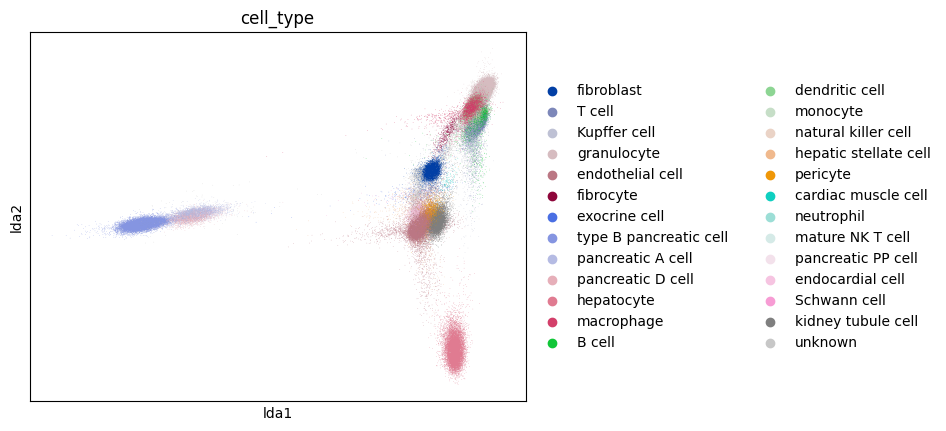

My LDA on (194315, 3480) took 14.90 seconds


In [7]:

def lda(adata):
    """
    Sklearn LDA fit and transform with timing and memory profiling.
    """
    # Sklearn LDA fit and transform
    start_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MiB
    lda = LDA(n_components=2)
    lda.fit(adata.X, adata.obs['cell_type'])
    X_new = lda.transform(adata.X)
    adata.obsm['X_lda'] = X_new
    end_mem = process.memory_info().rss / (1024 * 1024)  # Convert to MiB
    print(f"Memory usage increased by: {end_mem - start_mem:.2f} MiB")
    return X_new

start = time()
X_new = lda(adata=adata)
end = time()


sc.pl.embedding(adata=adata, basis="lda", color="cell_type")
print(f"My LDA on {adata.X.shape} took {end - start:.2f} seconds")


Memory usage increased by: 5603.12 MiB


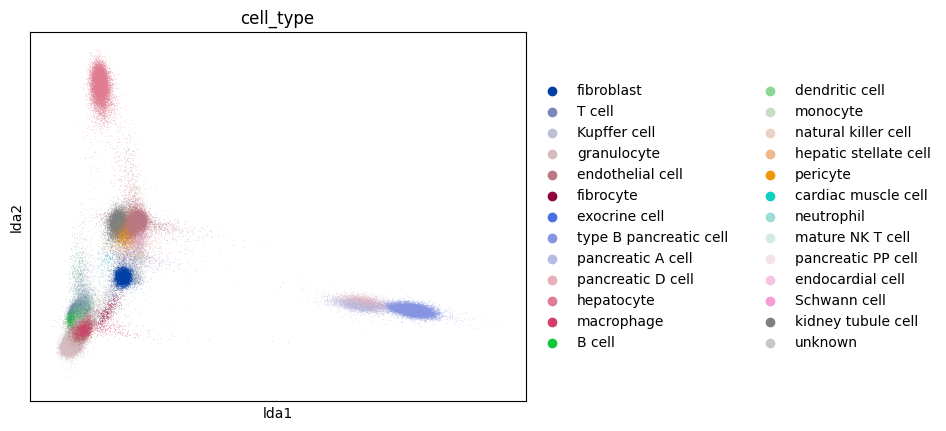

Sklearn LDA on (194315, 3480) took 63.82 seconds


In [8]:
from memory_profiler import memory_usage
def sklearn_lda(adata):
    """
    Sklearn LDA fit and transform with timing and memory profiling.
    """
    # Sklearn LDA fit and transform
    start_mem = process.memory_info().rss / (1024 * 1024)
    lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
    lda.fit(adata.X.toarray(), adata.obs['cell_type'])
    X_new = lda.transform(adata.X.toarray())
    adata.obsm['X_lda'] = X_new
    end_mem = process.memory_info().rss / (1024 * 1024)
    print(f"Memory usage increased by: {end_mem - start_mem:.2f} MiB")
    return X_new

start = time()
X_new = sklearn_lda(adata=adata)
end = time()
sc.pl.embedding(adata=adata, basis="lda", color="cell_type")
print(f"Sklearn LDA on {adata.X.shape} took {end - start:.2f} seconds")